In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import database as db
from datetime import timedelta

import anomaly_detection as ao

sns.set()

In [2]:
def run_anomalies(df, run_date, social_mod=None,
                  limit=95, horizon=12, simulations=10):   

    all_forcs = ao.anomaly_wrapper(df, run_date, horizon,
                                   simulations=simulations,
                                   social_mod=social_mod)

    forcs_df = (all_forcs.groupby(['region', 'cutoff', 'ds'])
                ['percent_ill']
                .describe(percentiles=[.025, 0.05, .1, .25, .5, .75, .9, .95, .975])
                .reset_index())

    # Be sure to grab the correct percentile...
    limit_dict = {90: '95%', 95: '97.5%'}

    forcs_df = forcs_df.merge(df[['region', 'percent_ill', 'ds']],
                              on=['region', 'ds'], how='outer')

    forcs_df['anomaly_diff'] = (forcs_df['percent_ill']
                                - forcs_df[limit_dict[limit]])
    forcs_df['anomaly_ili'] = np.where(forcs_df['anomaly_diff'] > 0,
                                       forcs_df['percent_ill'], np.nan)

    # Only keep the significant anomaly differences
    forcs_df['anomaly_diff'] = (forcs_df['anomaly_ili'] -
                                forcs_df[limit_dict[limit]])
    forcs_df['anomaly_diff'] = forcs_df['anomaly_diff'].fillna(0)
    
    return forcs_df


# Figure 1: Panel A and B

In [85]:
# Create the Brooklyn, NY and Miami, FL ensemble forecasting and anomaly detection example
# for Figure 1 Subplots
bk_df = pd.read_csv('data/brooklyn.csv')
bk_df['ds'] = pd.to_datetime(bk_df['ds'])

md_df = pd.read_csv('data/miami_dade.csv')
md_df['ds'] = pd.to_datetime(md_df['ds'])
md_df['doy'] = md_df.ds.dt.dayofyear

sc_df = pd.read_csv('data/santa_clara.csv')
sc_df['ds'] = pd.to_datetime(sc_df['ds'])

In [86]:
bk100 = run_anomalies(bk_df, ['2020-03-01'], simulations=100)
md100 = run_anomalies(md_df, ['2020-03-01'], simulations=100)
sc100 = run_anomalies(sc_df, ['2020-03-01'], simulations=100)

Forecasting for 36047


/Users/samchamberlain/.local/share/virtualenvs/therm_anomaly_detection-cYEoWQk6/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Forecasting for 12086
Forecasting for 6085


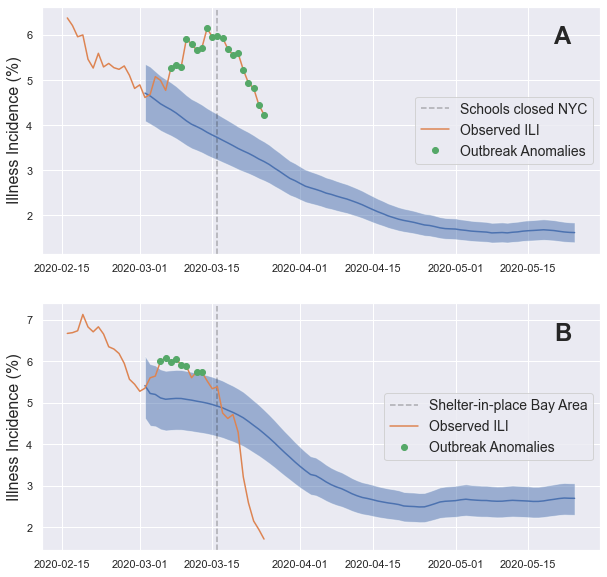

In [101]:
sub_bk = bk100[bk100.ds > '2020-02-15'].copy()
sub_bk.sort_values('ds', inplace=True)

sub_md = md100[md100.ds > '2020-02-15'].copy()
sub_md.sort_values('ds', inplace=True)

sub_md = sc100[sc100.ds > '2020-02-15'].copy()
sub_md.sort_values('ds', inplace=True)

# Figure 1: subplots A and B
fig, ax = plt.subplots(2, 1, figsize=(10, 10))

# Panel A: Brookly, NY Anomaly Detection
ax[0].axvline(pd.to_datetime('2020-03-16'), color='k', linestyle='--', alpha=0.3, label='Schools closed NYC')
ax[0].fill_between(sub_bk.ds, sub_bk['97.5%'], sub_bk['2.5%'], alpha=0.5)
ax[0].plot(sub_bk.ds, sub_bk['50%'], label='')
ax[0].plot(sub_bk.ds, sub_bk.percent_ill, label='Observed ILI')
ax[0].plot(sub_bk.ds, sub_bk.anomaly_ili, '.', ms=12, label='Outbreak Anomalies')

# Panel b: Miami Dade, FL Anomaly Detection
ax[1].axvline(pd.to_datetime('2020-03-16'), color='k', linestyle='--', alpha=0.3, label='Shelter-in-place Bay Area')
ax[1].fill_between(sub_md.ds, sub_md['97.5%'], sub_md['2.5%'], alpha=0.5)
ax[1].plot(sub_md.ds, sub_md['50%'], label='')
ax[1].plot(sub_md.ds, sub_md.percent_ill, label='Observed ILI')
ax[1].plot(sub_md.ds, sub_md.anomaly_ili, '.', ms=12, label='Outbreak Anomalies')

ax[0].set_ylabel('Illness Incidence (%)', fontsize=16)
ax[1].set_ylabel('Illness Incidence (%)', fontsize=16)
ax[0].legend(fontsize=14, loc='center right')
ax[1].legend(fontsize=14, loc='center right')
ax[0].text(pd.to_datetime('2020-05-20'), 5.8, 'A', fontsize=24, fontweight='bold')
ax[1].text(pd.to_datetime('2020-05-20'), 6.5, 'B', fontsize=24, fontweight='bold')
plt.savefig('Fig1AB.png', dpi=300)

## Figure 2: Panels A, B, C

In [90]:
# Figure 2: Impact of social distancing on three major counties (BK, SC, MIA)
# Distancing reductions of 25% influenza transmission
bk_distancing = run_anomalies(bk_df, ['2020-03-01'], social_mod=0.75, simulations=100)
md_distancing = run_anomalies(md_df, ['2020-03-01'], social_mod=0.75, simulations=100)
sc_distancing = run_anomalies(sc_df, ['2020-03-01'], social_mod=0.75, simulations=100)

Forecasting for 36047


/Users/samchamberlain/.local/share/virtualenvs/therm_anomaly_detection-cYEoWQk6/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Forecasting for 12086
Forecasting for 6085


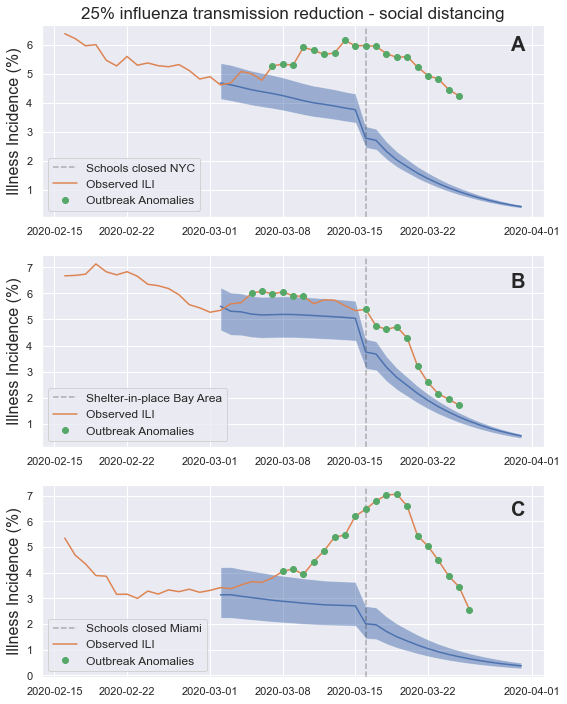

In [102]:
### Social distancing estimate in Brooklyn

bk_75 = bk_distancing[(bk_distancing.ds >= '2020-02-15') &
                      (bk_distancing.ds <= '2020-04-15')].copy()
bk_75.sort_values('ds', inplace=True)

md_75 = md_distancing[(md_distancing.ds >= '2020-02-15') &
                      (md_distancing.ds <= '2020-04-15')].copy()
md_75.sort_values('ds', inplace=True)

sc_75 = sc_distancing[(sc_distancing.ds >= '2020-02-15') &
                      (sc_distancing.ds <= '2020-04-15')].copy()
sc_75.sort_values('ds', inplace=True)

fig, ax = plt.subplots(3, 1, figsize=(9, 12))

ax[0].axvline(pd.to_datetime('2020-03-16'), color='k', linestyle='--', alpha=0.3, label='Schools closed NYC')
ax[0].fill_between(bk_75.ds, bk_75['97.5%'], bk_75['2.5%'], alpha=0.5)
ax[0].plot(bk_75.ds, bk_75['50%'], label='')
ax[0].plot(bk_75.ds, bk_75.percent_ill, label='Observed ILI')
ax[0].plot(bk_75.ds, bk_75.anomaly_ili, '.', ms=12, label='Outbreak Anomalies')

ax[1].axvline(pd.to_datetime('2020-03-16'), color='k', linestyle='--', alpha=0.3, label='Shelter-in-place Bay Area')
ax[1].fill_between(sc_75.ds, sc_75['97.5%'], sc_75['2.5%'], alpha=0.5)
ax[1].plot(sc_75.ds, sc_75['50%'], label='')
ax[1].plot(sc_75.ds, sc_75.percent_ill, label='Observed ILI')
ax[1].plot(sc_75.ds, sc_75.anomaly_ili, '.', ms=12, label='Outbreak Anomalies')

ax[2].axvline(pd.to_datetime('2020-03-16'), color='k', linestyle='--', alpha=0.3, label='Schools closed Miami')
ax[2].fill_between(md_75.ds, md_75['97.5%'], md_75['2.5%'], alpha=0.5)
ax[2].plot(md_75.ds, md_75['50%'], label='')
ax[2].plot(md_75.ds, md_75.percent_ill, label='Observed ILI')
ax[2].plot(md_75.ds, md_75.anomaly_ili, '.', ms=12, label='Outbreak Anomalies')


ax[0].set_ylabel('Illness Incidence (%)', fontsize=16)
ax[1].set_ylabel('Illness Incidence (%)', fontsize=16)
ax[2].set_ylabel('Illness Incidence (%)', fontsize=16)
ax[0].legend(fontsize=12, loc='lower left')
ax[1].legend(fontsize=12, loc='lower left')
ax[2].legend(fontsize=12, loc='lower left')
ax[0].set_title('25% influenza transmission reduction - social distancing', fontsize=17)

ax[0].text(pd.to_datetime('2020-03-30'), 5.8, 'A', fontsize=20, fontweight='bold')
ax[1].text(pd.to_datetime('2020-03-30'), 6.2, 'B', fontsize=20, fontweight='bold')
ax[2].text(pd.to_datetime('2020-03-30'), 6.2, 'C', fontsize=20, fontweight='bold')

plt.savefig('Fig2.png', dpi=300)

## Supplemental Figures

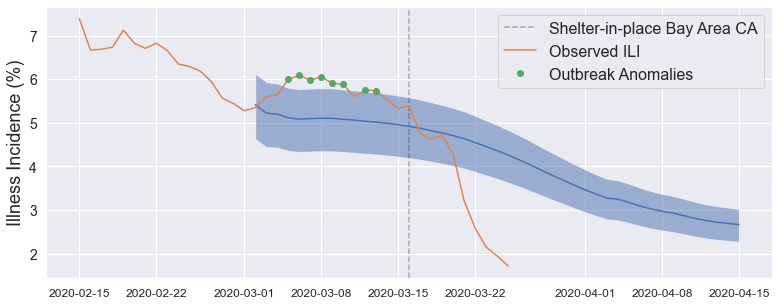

In [112]:
sub_sc = sc100[(sc100.ds >= '2020-02-15') &
               (sc100.ds <= '2020-04-15')].copy()
sub_sc.sort_values('ds', inplace=True)

plt.figure(figsize=(13, 5))
plt.axvline(pd.to_datetime('2020-03-16'), color='k', linestyle='--',
            alpha=0.3, label='Shelter-in-place Bay Area CA')
plt.fill_between(sub_sc.ds, sub_sc['97.5%'], sub_sc['2.5%'], alpha=0.5)
plt.plot(sub_sc.ds, sub_sc['50%'], label='')
plt.plot(sub_sc.ds, sub_sc.percent_ill, label='Observed ILI')
plt.plot(sub_sc.ds, sub_sc.anomaly_ili, '.', ms=12, label='Outbreak Anomalies')
plt.ylabel('Illness Incidence (%)', fontsize=18)
plt.yticks(fontsize=14)
plt.xticks(fontsize=12)
plt.legend(fontsize=16)
plt.savefig('FigS2.png', dpi=300)

In [138]:
# Now, how does this effect our correlations to COVID cases?
# Well, in Brooklyn we don't have easily available counts, so we will run a sensitivity analysis
# across a range of reduced transmission rates to assess the impact on correlations
covid = pd.read_csv('data/timeseries-jhu.csv')

sc_covid = covid[(covid.county == 'Santa Clara County')]
sc_covid= sc_covid.drop(['lat', 'long', 'city', 'state', 'country', 'population', 'url'],
                        axis=1)
sc_covid = sc_covid.melt(id_vars='county', var_name='ds', value_name='cases')
sc_covid['ds'] = pd.to_datetime(sc_covid.ds, format='%Y-%m-%d')
sc_covid = sc_covid[sc_covid.ds > '2020-03-01']

md_covid = covid[covid.county == 'Miami-Dade County']
md_covid= md_covid.drop(['lat', 'long', 'city', 'state', 'country', 'population', 'url'],
                        axis=1)
md_covid = md_covid.melt(id_vars='county', var_name='ds', value_name='cases')
md_covid['ds'] = pd.to_datetime(md_covid.ds, format='%Y-%m-%d')
md_covid = md_covid[md_covid.ds > '2020-03-01']

# complete COVID data is only available for the entire state
ny_covid = covid[(covid.state == 'NY') & (covid.county.isna()) & (covid.city.isna())]
ny_covid= ny_covid.drop(['lat', 'long', 'city', 'county', 'country', 'population', 'url'],
                        axis=1)
ny_covid = ny_covid.melt(id_vars='state', var_name='ds', value_name='cases')
ny_covid['ds'] = pd.to_datetime(ny_covid.ds, format='%Y-%m-%d')
ny_covid = ny_covid[ny_covid.ds > '2020-03-01']

In [141]:
# Now, let's look at how the correlations between cumulative anomaly incidence
# and total COVID cases vary with distancing reductions in transmission
# look at reductions down to 50% below standard
r_reduction = [1, 0.95, 0.90, 0.85, 0.80, 0.75]

def distance_calcs(df, r_reduction):
    dfs = []

    for distance in r_reduction:
        print(f'Running distancing at {distance}')
        out = run_anomalies(df, ['2020-03-01'], social_mod=distance, simulations=50)
        out['distancing'] = 1 - distance
        dfs.append(out)

    return pd.concat(dfs, axis=0)

# Run distancing drops for all cities, dropped simulations to 50 ensemble for computation time
sc_distancing = distance_calcs(sc_df, r_reduction)
bk_distancing = distance_calcs(bk_df, r_reduction)
md_distancing = distance_calcs(md_df, r_reduction)

Running distancing at 1
Forecasting for 6085


/Users/samchamberlain/.local/share/virtualenvs/therm_anomaly_detection-cYEoWQk6/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Running distancing at 0.95
Forecasting for 6085
Running distancing at 0.9
Forecasting for 6085
Running distancing at 0.85
Forecasting for 6085
Running distancing at 0.8
Forecasting for 6085
Running distancing at 0.75
Forecasting for 6085
Running distancing at 1
Forecasting for 36047
Running distancing at 0.95
Forecasting for 36047
Running distancing at 0.9
Forecasting for 36047
Running distancing at 0.85
Forecasting for 36047
Running distancing at 0.8
Forecasting for 36047
Running distancing at 0.75
Forecasting for 36047
Running distancing at 1
Forecasting for 12086
Running distancing at 0.95
Forecasting for 12086
Running distancing at 0.9
Forecasting for 12086
Running distancing at 0.85
Forecasting for 12086
Running distancing at 0.8
Forecasting for 12086
Running distancing at 0.75
Forecasting for 12086


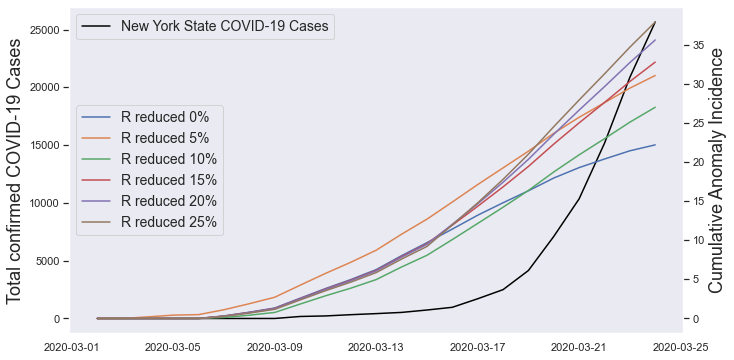

In [142]:
# Figure S3: Sensitivity to social distancing 
ny_input = bk_distancing[(bk_distancing.ds >= ny_covid.ds.min()) &
                         (bk_distancing.ds <= ny_covid.ds.max())]

fig, ax1 = plt.subplots(figsize=(11, 6))
ax2 = ax1.twinx()
for distancing in r_reduction:
    sub = ny_input[ny_input.distancing == (1 - distancing)].copy()
    sub['cumulative_anom'] = sub['anomaly_diff'].cumsum()
    sub.sort_values('ds', inplace=True)
    ax2.plot(sub.ds, sub.cumulative_anom,
             label=f'R reduced {round((1 - distancing)*100)}%')
ax1.plot(ny_covid.ds, ny_covid.cases, color='black', label='New York State COVID-19 Cases')

ax1.set_xlabel('')
ax1.set_ylabel('Total confirmed COVID-19 Cases', fontsize=18)
ax2.set_ylabel('Cumulative Anomaly Incidence', fontsize=18)
ax1.grid(False)
ax2.grid(False)
ax1.legend(fontsize=14)
ax2.legend(loc='center left', fontsize=14)
plt.savefig('FigS3.png', dpi=300)

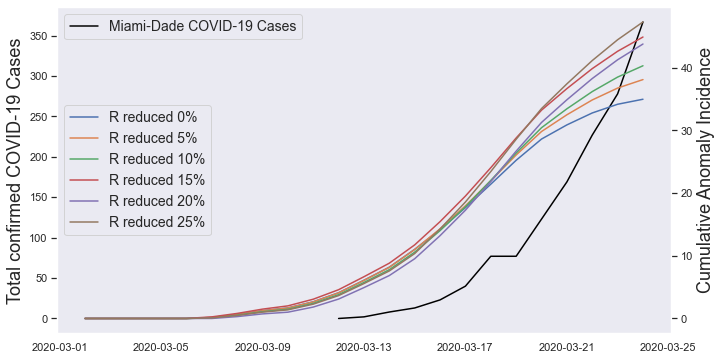

In [143]:
md_input = md_distancing[(md_distancing.ds >= md_covid.ds.min()) &
                         (md_distancing.ds <= md_covid.ds.max())]

fig, ax1 = plt.subplots(figsize=(11, 6))
ax2 = ax1.twinx()
for distancing in r_reduction:
    sub = md_input[md_input.distancing == (1 - distancing)].copy()
    sub['cumulative_anom'] = sub['anomaly_diff'].cumsum()
    sub.sort_values('ds', inplace=True)
    ax2.plot(sub.ds, sub.cumulative_anom,
             label=f'R reduced {round((1 - distancing)*100)}%')
ax1.plot(md_covid.ds, md_covid.cases, color='black', label='Miami-Dade COVID-19 Cases')

ax1.set_xlabel('')
ax1.set_ylabel('Total confirmed COVID-19 Cases', fontsize=18)
ax2.set_ylabel('Cumulative Anomaly Incidence', fontsize=18)
ax1.grid(False)
ax2.grid(False)
ax1.legend(fontsize=14)
ax2.legend(loc='center left', fontsize=14)
plt.savefig('FigS4.png', dpi=300)

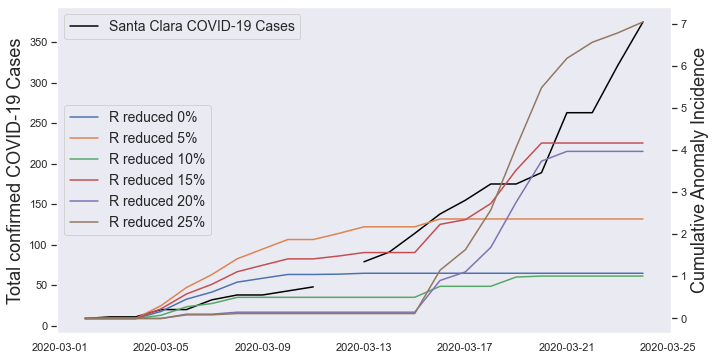

In [145]:
sc_input = sc_distancing[(sc_distancing.ds >= sc_covid.ds.min()) &
                         (sc_distancing.ds <= sc_covid.ds.max())]

fig, ax1 = plt.subplots(figsize=(11, 6))
ax2 = ax1.twinx()
for distancing in r_reduction:
    sub = sc_input[sc_input.distancing == (1 - distancing)].copy()
    sub['cumulative_anom'] = sub['anomaly_diff'].cumsum()
    sub.sort_values('ds', inplace=True)
    ax2.plot(sub.ds, sub.cumulative_anom,
             label=f'R reduced {round((1 - distancing)*100)}%')
ax1.plot(sc_covid.ds, sc_covid.cases, color='black', label='Santa Clara COVID-19 Cases')

ax1.set_xlabel('')
ax1.set_ylabel('Total confirmed COVID-19 Cases', fontsize=18)
ax2.set_ylabel('Cumulative Anomaly Incidence', fontsize=18)
ax1.grid(False)
ax2.grid(False)
ax1.legend(fontsize=14)
ax2.legend(loc='center left', fontsize=14)
plt.savefig('FigS5.png', dpi=300)

In [165]:
## How do these changes in R correlate to overall COVID cases per region
def correlate_covid(df, covid_df):
    cumul_df = (df.groupby(['ds', 'distancing'])['anomaly_diff']
               .mean()
               .groupby('distancing').cumsum()
               .to_frame().reset_index()
               .merge(covid_df, on='ds'))

    corr_df = (cumul_df.groupby('distancing')
              ['anomaly_diff', 'cases']
              .corr(method='pearson')
              .unstack().reset_index())
    
    return corr_df

corr_sc = correlate_covid(sc_input, sc_covid)
corr_ny = correlate_covid(ny_input, ny_covid)
corr_md = correlate_covid(md_input, md_covid)

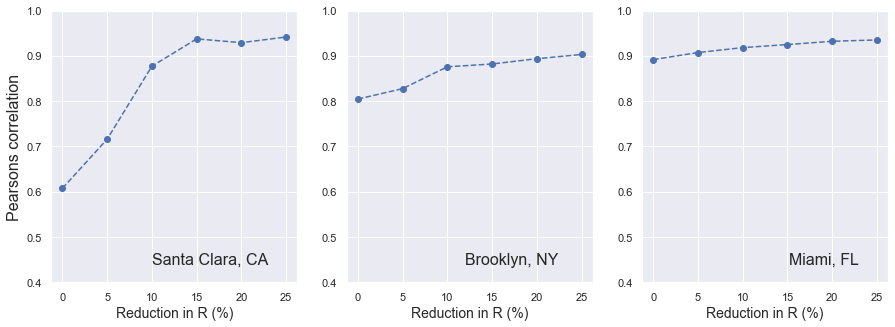

In [194]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].plot(corr_sc['distancing']*100, corr_sc['anomaly_diff']['cases'], linestyle='--', marker='o',)
ax[0].set_ylabel('Pearsons correlation', fontsize=16)
ax[0].set_xlabel('Reduction in R (%)', fontsize=14)

ax[1].plot(corr_ny['distancing']*100, corr_ny['anomaly_diff']['cases'], linestyle='--', marker='o',)
ax[1].set_xlabel('Reduction in R (%)', fontsize=14);

ax[2].plot(corr_md['distancing']*100, corr_md['anomaly_diff']['cases'], linestyle='--', marker='o',)
ax[2].set_xlabel('Reduction in R (%)', fontsize=14);

ax[0].set_ylim(0.4, 1)
ax[1].set_ylim(0.4, 1)
ax[2].set_ylim(0.4, 1)

ax[0].text(10, .44, 'Santa Clara, CA', fontsize=16)
ax[1].text(12, .44, 'Brooklyn, NY', fontsize=16)
ax[2].text(15.2, .44, 'Miami, FL', fontsize=16)
plt.savefig('FigS6.png', dpi=300)

In [215]:
## Now for the Santa Clara example
sc_df = pd.read_csv('data/santa_clara.csv')
sc_df['ds'] = pd.to_datetime(sc_df['ds'])

In [216]:
sc100 = run_anomalies(sc_df, ['2020-03-01'], simulations=100)
sc_distancing = run_anomalies(sc_df, ['2020-03-01'], social_mod=0.85, simulations=100)

Forecasting for 6085


/Users/samchamberlain/.local/share/virtualenvs/therm_anomaly_detection-cYEoWQk6/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Forecasting for 6085


(1.0, 7.5)

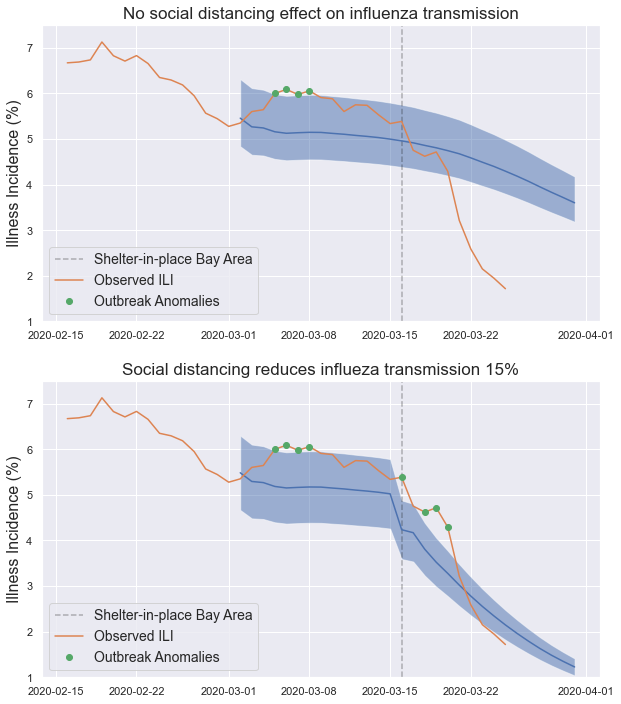

In [217]:
### Social distancing example in Santa Clara, CA
sc_85 = sc_distancing[(sc_distancing.ds > '2020-02-15') &
                      (sc_distancing.ds < '2020-04-01')].copy()
sc_85.sort_values('ds', inplace=True)

sc_100 = sc100[(sc100.ds > '2020-02-15') &
               (sc100.ds < '2020-04-01')].copy()
sc_100.sort_values('ds', inplace=True)

fig, ax = plt.subplots(2, 1, figsize=(10, 12))

ax[0].axvline(pd.to_datetime('2020-03-16'), color='k', linestyle='--', alpha=0.3, label='Shelter-in-place Bay Area')
ax[0].fill_between(sc_100.ds, sc_100['97.5%'], sc_100['2.5%'], alpha=0.5)
ax[0].plot(sc_100.ds, sc_100['50%'], label='')
ax[0].plot(sc_100.ds, sc_100.percent_ill, label='Observed ILI')
ax[0].plot(sc_100.ds, sc_100.anomaly_ili, '.', ms=12, label='Outbreak Anomalies')

ax[1].axvline(pd.to_datetime('2020-03-16'), color='k', linestyle='--', alpha=0.3, label='Shelter-in-place Bay Area')
ax[1].fill_between(sc_85.ds, sc_85['97.5%'], sc_85['2.5%'], alpha=0.5)
ax[1].plot(sc_85.ds, sc_85['50%'], label='')
ax[1].plot(sc_85.ds, sc_85.percent_ill, label='Observed ILI')
ax[1].plot(sc_85.ds, sc_85.anomaly_ili, '.', ms=12, label='Outbreak Anomalies')

ax[0].set_ylabel('Illness Incidence (%)', fontsize=16)
ax[1].set_ylabel('Illness Incidence (%)', fontsize=16)
ax[0].legend(fontsize=14, loc='lower left')
ax[1].legend(fontsize=14, loc='lower left')
ax[0].set_title('No social distancing effect on influenza transmission', fontsize=17)
ax[1].set_title('Social distancing reduces influeza transmission 15%', fontsize=17)
ax[0].set_ylim(1, 7.5)
ax[1].set_ylim(1, 7.5)
#plt.savefig('Figure S2.png', dpi=300)

In [218]:
# Now, how does this effect our correlations to COVID cases?
# Well, in Brooklyn we don't have easily available counts, so we will run a sensitivity analysis
# across a range of reduced transmission rates to assess the impact on correlations
covid = pd.read_csv('data/timeseries-jhu.csv')

sc_covid = covid[(covid.county == 'Santa Clara County')]
sc_covid= sc_covid.drop(['lat', 'long', 'city', 'state', 'country', 'population', 'url'], axis=1)
sc_covid = sc_covid.melt(id_vars='county', var_name='ds', value_name='cases')
sc_covid['ds'] = pd.to_datetime(sc_covid.ds, format='%Y-%m-%d')
sc_covid = sc_covid[sc_covid.ds > '2020-03-01']

# complete COVID data from JHU is only available for the entire state
#ny_covid = covid[(covid.state == 'NY') & (covid.county.isna()) & (covid.city.isna())]
ny_covid= covid[covid.county == 'Miami-Dade County']
ny_covid= ny_covid.drop(['lat', 'long', 'city', 'county', 'country', 'population', 'url'], axis=1)
ny_covid = ny_covid.melt(id_vars='state', var_name='ds', value_name='cases')
ny_covid['ds'] = pd.to_datetime(ny_covid.ds, format='%Y-%m-%d')
ny_covid = ny_covid[ny_covid.ds > '2020-03-01']

In [219]:
# Now, let's look at how the correlations between cumulative anomaly incidence
# and total COVID cases vary with distancing reductions in transmission
# look at reductions down to 25% below standard

dfs = []

for distance in [1, 0.95, 0.90, 0.85, 0.80, 0.75]:
    print(f'Running distancing at {distance}')
    out = run_anomalies(bk_df, ['2020-03-01'], social_mod=distance, simulations=10)
    out['distancing'] = 1 - distance
    dfs.append(out)
    
bk_distancing = pd.concat(dfs, axis=0)

Running distancing at 1
Forecasting for 12086


/Users/samchamberlain/.local/share/virtualenvs/therm_anomaly_detection-cYEoWQk6/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Running distancing at 0.95
Forecasting for 12086
Running distancing at 0.9
Forecasting for 12086
Running distancing at 0.85
Forecasting for 12086
Running distancing at 0.8
Forecasting for 12086
Running distancing at 0.75
Forecasting for 12086
